# 一、准备数据

In [0]:
# 准备数据集
!wget https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip
!unzip -q Mathematical_Expression_Recognition_train.zip
!ls

--2019-03-18 01:01:34--  https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip
Resolving s3.cn-north-1.amazonaws.com.cn (s3.cn-north-1.amazonaws.com.cn)... 54.222.50.85
Connecting to s3.cn-north-1.amazonaws.com.cn (s3.cn-north-1.amazonaws.com.cn)|54.222.50.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328117062 (313M) [application/zip]
Saving to: ‘Mathematical_Expression_Recognition_train.zip’

Mathematical_Expres 100%[===================>] 312.92M  12.8MB/s    in 50s     

2019-03-18 01:02:28 (6.30 MB/s) - ‘Mathematical_Expression_Recognition_train.zip’ saved [328117062/328117062]

Mathematical_Expression_Recognition_train.zip  sample_data  train  train.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

!pip install livelossplot -q

In [52]:
labels_data = pd.read_csv('./train.csv')

labels_data.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


In [0]:
def show_imgs(imgs, titles, col=1, figsize=(8, 3)):
    fig = plt.figure(figsize=figsize)
    rows = len(imgs)//col+1
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(rows, col, i+1)
        ax.imshow(img)
        ax.set(title=titles[i])
        ax.grid(False)
    fig.show()

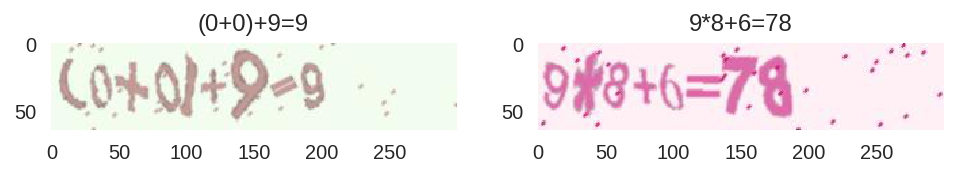

In [4]:
imgs = []
titles = []
imgs.append(plt.imread(labels_data['filename'][0]))
imgs.append(plt.imread(labels_data['filename'][1]))

titles.append(labels_data['label'][0])
titles.append(labels_data['label'][1])

show_imgs(imgs, titles, 2)

# 二、 数据探索

### 长度最大的标签

In [5]:
# 标签的最大值
labels_data.label.str.len().max()

11

### 标签长度分布

Text(0, 0.5, 'data size')

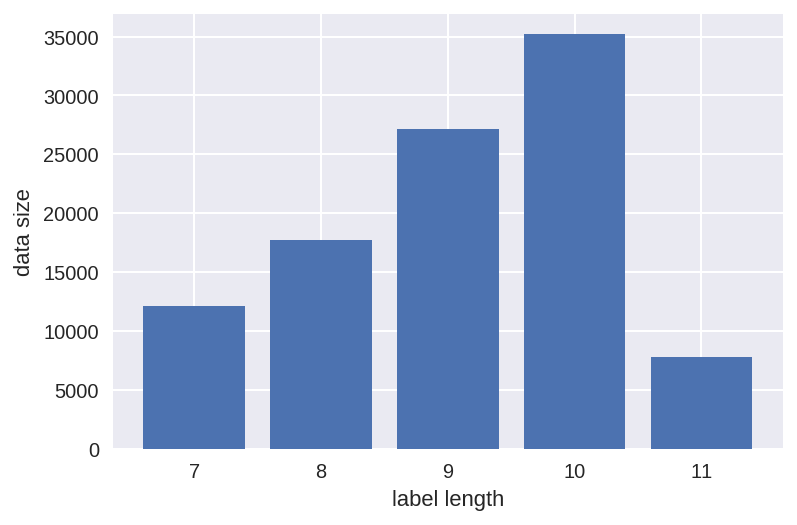

In [54]:
from collections import defaultdict

d = defaultdict(int)
for label in labels_data['label']:
    d[len(label)] += 1
    
plt.bar(d.keys(), d.values())
plt.xlabel('label length')
plt.ylabel('data size')

# 三、 预处理

## 1. 灰度化

In [0]:
img0 = cv2.imread(labels_data['filename'][0], cv2.IMREAD_GRAYSCALE)  # (w, h)

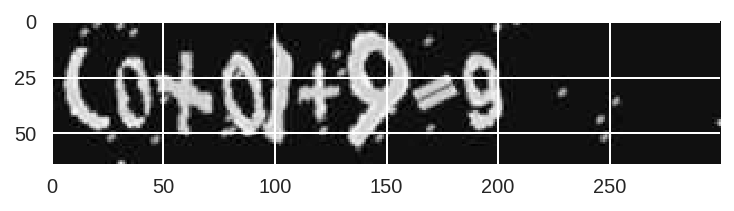

In [57]:
plt.imshow(img0)

## 2. 归一化与中心化

In [0]:
img0 = img0 / 255 * 2 - 1

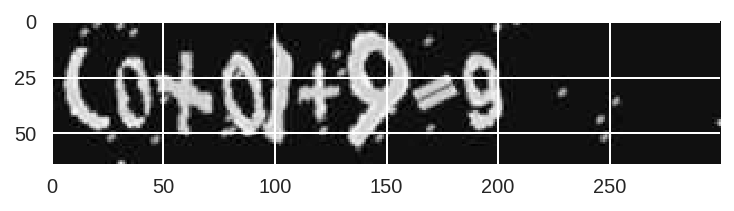

In [59]:
plt.imshow(img0)

# 四、搭建模型

### 配置信息

In [0]:
import cv2
import matplotlib.pyplot as plt

# Configuration
characters = '-+*()=0123456789'
num_of_chars = len(characters) + 1

characters_list = [char for char in characters]
characters_list.append(' ')

max_text_len = 17
img_width = 64
img_height = 300
img_channel = 3
time_steps = 18

batch_size = 100
valid_batch_size = 100

predict_valid_batch_size = 100

epoch_n = 40


def text_to_index(text):
    return [characters_list.index(char) for char in text]


def index_to_text(index):
    return [characters_list[i] for i in index]


### 数据生成

In [0]:
class DataGenerator:
    def __init__(self, img_paths, labels, img_w, img_h, img_channels, max_label_length, batch_size, shuffle=True):
        self.img_paths = img_paths
        self.labels = labels
        self.img_width = img_w
        self.img_height = img_h
        self.img_channels = img_channels
        self.max_label_length = max_label_length
        self.num_of_samples = len(img_paths)
        self.cur_index = 0
        self.indexes = list(range(self.num_of_samples))
        self.batch_size = batch_size
        self.shuffle = shuffle

    def next_sample(self):
        if self.cur_index >= self.num_of_samples:
            if self.shuffle:
                np.random.shuffle(self.indexes)
            self.cur_index = 0
        img_path_idx = self.indexes[self.cur_index]
#         img = cv2.imread(self.img_paths[img_path_idx], cv2.IMREAD_GRAYSCALE)  # (w, h)
        img = cv2.imread(self.img_paths[img_path_idx])  # (w, h, ch)
        img = img / 255 * 2 - 1  # 归一化，中心化
#         img = np.expand_dims(img, axis=2)[None, :]  # (bs, w, h, ch)
        label_str = self.labels[self.indexes[self.cur_index]]
        label_index = np.array(text_to_index(label_str)).reshape((1, -1))  # Like: `0+1=1` ===> [[6, 1, 7, 5, 7]]
        self.cur_index += 1
        return img, label_index

    def next_batch(self):
        while True:
            the_inputs = np.zeros(shape=(self.batch_size, self.img_width, self.img_height, self.img_channels))
            y_true = np.zeros(shape=(self.batch_size, self.max_label_length))
            input_length = np.ones(shape=(self.batch_size, 1)) * time_steps
            label_length = np.zeros(shape=(self.batch_size, 1))

            for i in range(self.batch_size):
                img, input_label = self.next_sample()
                the_inputs[i] = img
                y_true[i, :input_label.shape[1]] = input_label
                label_length[i] = input_label.shape[1]

            inputs = {
                'inputs': the_inputs,
                'the_labels': y_true,
                'input_length': input_length,
                'label_length': label_length,
            }

            outputs = np.zeros(shape=(self.batch_size, 1))

            yield inputs, outputs
            
    
    def reset(self):
        self.cur_index = 0


### 搭建模型

In [13]:
# 搭建神经网络

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Reshape, Lambda, Input, \
    Activation, TimeDistributed, Permute, Flatten
from keras.layers import Bidirectional, LSTM
import keras.backend as backend
from keras.callbacks import Callback

from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.keras import PlotLossesCallback

from sklearn.model_selection import train_test_split

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
#     y_pred = y_pred[:, 2:, :]
    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [0]:
# Data split, train:valid:test = 8:1:1

image_paths = labels_data['filename']
image_labels = labels_data['label']

train_X, valid_X, test_X = image_paths[:80000].reset_index(drop=True), image_paths[80000:90000].reset_index(drop=True), image_paths[90000:].reset_index(drop=True)
train_y, valid_y, test_y = image_labels[:80000].reset_index(drop=True), image_labels[80000:90000].reset_index(drop=True), image_labels[90000:].reset_index(drop=True)


In [0]:
def remove_consecutive_duplicate(text_indexes):
    if text_indexes == '':
        return text_indexes
    i = 0
    while True:
        if i+1 >= len(text_indexes):
            break
        if text_indexes[i+1] == text_indexes[i]:
            del text_indexes[i]
        else:
            i += 1
    return text_indexes

def decode_ctc(y_pred):
    pred_label_index_list = list(np.argmax(y_pred, axis=2))
    label_strs = []
    # print(pred_label_index_list)
    for pred_label_indexes in pred_label_index_list:
        char_indexes = remove_consecutive_duplicate(list(pred_label_indexes))
        # print("char_indexes:", char_indexes)
        label_strs.append(''.join(index_to_text(char_indexes)))

    return list(map(lambda s: s.replace(' ', ''), label_strs))


class MetricsCallback(Callback):

    def __init__(self, model, X_generator, y, metrics_type='valid', load_best_weights=False):
        super().__init__()
        self.base_model = model
        self.X_generator = X_generator
        self.labels = y
        self.accs = []
        self.load_best_weights = load_best_weights
        self.metrics_type = metrics_type
        self.train_loss = []
        
    def on_batch_end(self, batch, logs=None):
        self.train_loss.append(logs['loss'])

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.validate()

    def validate(self):
        self.X_generator.reset()
        if self.load_best_weights:
            self.base_model.load_weights('Model_best.hdf5')
        preds = self.base_model.predict_generator(self.X_generator.next_batch(), verbose=1, steps=int(len(self.labels) / self.X_generator.batch_size))
        val_loss = preds[0]
        print("val_loss.size:{}, mean:{}".format(val_loss.shape[0], val_loss.mean()))
        pred_softmax = preds[1]
        print("pred_softmax.size:", pred_softmax.shape)
        pred_strs = decode_ctc(pred_softmax)

        right = 0
        for pred, ground_true in zip(pred_strs, self.labels):
            if pred == ground_true:
                right += 1
        acc = right * 1.0 / len(self.labels)
        self.accs.append(acc)
        print("{} accuracy: {:.2%}".format(self.metrics_type, acc))

### 模型



In [0]:
from keras import applications
# vgg = applications.VGG19(input_shape=(img_width, img_height, img_channel), weights="imagenet", include_top=False)
# vgg.layers.pop()
# vgg.outputs = [vgg.layers[-1].output]
# vgg.layers[-1].outbound_nodes = []
# layer_dict = dict([(layer.name, layer) for layer in vgg.layers])

# vgg.summary()

# for l in vgg.layers:
#     l.trainable = False

def get_model():
    # CNN
    vgg = applications.VGG19(input_shape=(img_width, img_height, img_channel), weights="imagenet",
                                   include_top=False)
    for l in vgg.layers:
        l.trainable = True
    vgg.layers[0].name = 'inputs'
    layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
    # vgg_out = vgg_model(inputs)
    inner = layer_dict['block5_conv4'].output
    
    inner = BatchNormalization()(inner)

    # CNN to RNN
    inner = Permute((2, 1, 3))(inner)
    inner = TimeDistributed(Flatten())(inner)

    # RNN
    bi_lstm1 = Bidirectional(
        LSTM(64, return_sequences=True, kernel_initializer='he_normal', name='Bi_lstm1', go_backwards=True),
        merge_mode='sum')(inner)
    bi_lstm2 = Bidirectional(
        LSTM(64, return_sequences=True, kernel_initializer='he_normal', name='Bi_lstm2', go_backwards=True),
        merge_mode='sum')(bi_lstm1)
    inner = Dense(num_of_chars)(bi_lstm2)
    y_pred = Activation('softmax', name='y_pred_softmax')(inner)

    labels = Input(name='the_labels', shape=(max_text_len,), dtype='int64')
    input_length = Input(name='input_length', shape=(1,), dtype='int64')
    label_length = Input(name='label_length', shape=(1,), dtype='int64')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([y_pred, labels, input_length, label_length])

    return Model(inputs=[vgg.input, labels, input_length, label_length], outputs=[loss_out, y_pred])


In [17]:
model = get_model()
model.compile(loss={'ctc_loss': lambda y_true, y_pred: y_pred}, optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 300, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 300, 64)  1792        inputs[0][0]                     
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 300, 64)  36928       block1_conv1[0][0]               
__________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Output "y_pred_softmax" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "y_pred_softmax" during training.
  


In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
from livelossplot.keras import PlotLossesCallback

train_data_generator = DataGenerator(img_paths=train_X,
                                     labels=train_y,
                                     img_w=img_width,
                                     img_h=img_height,
                                     img_channels=img_channel,
                                     max_label_length=max_text_len,
                                     batch_size=batch_size)
valid_data_generator = DataGenerator(img_paths=valid_X,
                                     labels=valid_y,
                                     img_w=img_width,
                                     img_h=img_height,
                                     img_channels=img_channel,
                                     max_label_length=max_text_len,
                                     batch_size=valid_batch_size,
                                     shuffle=False)

acc_valid_generator = DataGenerator(valid_X, valid_y, img_width, img_height, img_channel, max_text_len, predict_valid_batch_size, shuffle=False)
acc_callback = MetricsCallback(model, acc_valid_generator, valid_y)
early_stop_cb = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

checkpoint = ModelCheckpoint(filepath='Model_best.hdf5', monitor='val_loss', verbose=1, mode='min', period=1, save_best_only=True)

hist = model.fit_generator(generator=train_data_generator.next_batch(),
                   steps_per_epoch=int(train_data_generator.num_of_samples/batch_size),
                   epochs=epoch_n,
                   callbacks=[checkpoint, acc_callback, early_stop_cb],
                   validation_data=valid_data_generator.next_batch(),
                   validation_steps=int(valid_data_generator.num_of_samples/valid_batch_size))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/40
800/800 [==============================] - 1314s 2s/step - loss: 13.5868 - ctc_loss_loss: 13.5868 - val_loss: 39.4569 - val_ctc_loss_loss: 39.4569

Epoch 00001: val_loss improved from inf to 39.45690, saving model to Model_best.hdf5
100/100 [==============================] - 63s 625ms/step
val_loss.size:10000, mean:39.45690155029297
pred_softmax.size: (10000, 18, 17)
valid accuracy: 0.00%
Epoch 2/40
800/800 [==============================] - 1292s 2s/step - loss: 2.1273 - ctc_loss_loss: 2.1273 - val_loss: 2.9996 - val_ctc_loss_loss: 2.9996

Epoch 00002: val_loss improved from 39.45690 to 2.99956, saving model to Model_best.hdf5
100/100 [==============================] - 61s 607ms/step
val_loss.size:10000, mean:2.999560832977295
pred_softmax.size: (10000, 18, 17)
valid accuracy: 23.88%
Epoch 3/40
800/800 [==============================] - 1290s 2s/step - loss: 0.3632 - ctc_loss_loss: 0.3632 - val_lo

In [23]:
hist.history.keys()

dict_keys(['val_loss', 'val_ctc_loss_loss', 'loss', 'ctc_loss_loss'])

Text(0.5, 1.0, 'Model loss per batch')

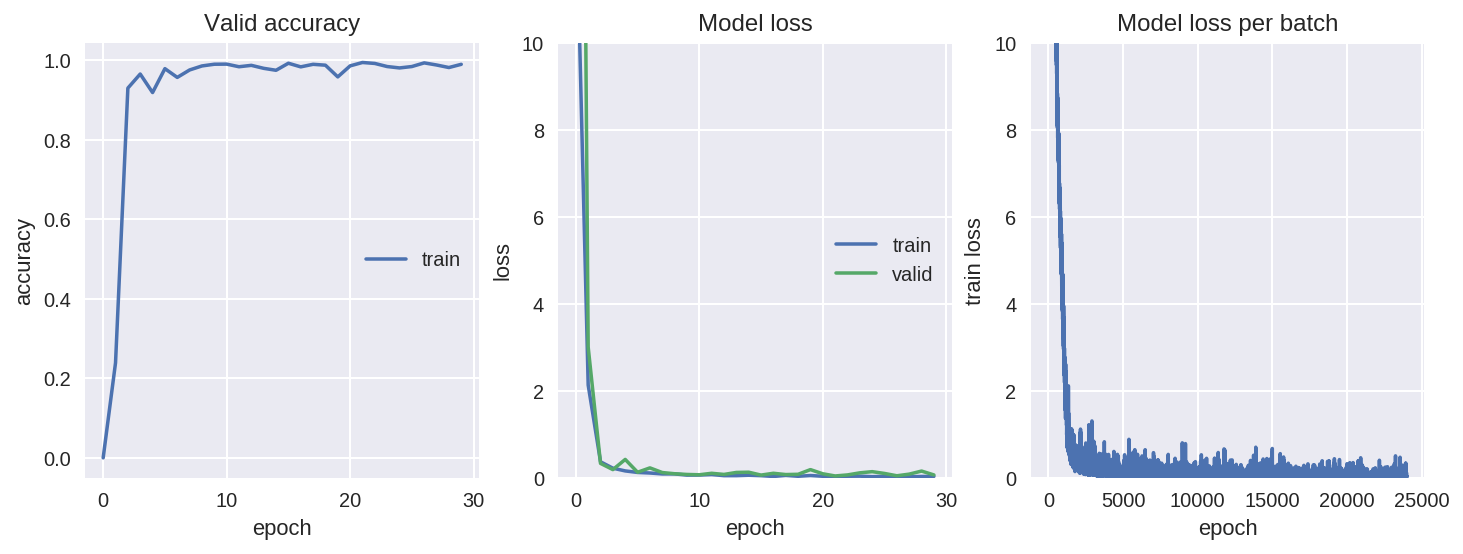

In [29]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

ax1.plot(acc_callback.accs)
# ax1.plot(hist.history['val_acc'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
# ax1.set_xlim(0, epoch_n)
ax1.set_title('Valid accuracy')
ax1.legend(['train', 'valid'], loc='center right')

ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
# ax2.set_xlim(0, epoch_n)
ax2.set_ylim(0, 10)
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model loss')
ax2.legend(['train', 'valid'], loc='center right')

ax3 = fig.add_subplot(133)
ax3.plot(acc_callback.train_loss)
# ax3.set_xlim(0, epoch_n)
ax3.set_ylim(0, 10)
ax3.set_xlabel('epoch')
ax3.set_ylabel('train loss')
ax3.set_title('Model loss per batch')
# ax3.legend(['train', 'valid'], loc='center right')

In [21]:
acc_test_generator = DataGenerator(test_X, test_y, img_width, img_height, img_channel, max_text_len, 16, False)
cb = MetricsCallback(model, acc_test_generator, test_y, load_best_weights=True)
cb.validate()

625/625 [==============================] - 113s 182ms/step
val_loss.size:10000, mean:0.036475770175457
pred_softmax.size: (10000, 18, 17)
valid accuracy: 99.33%
